In [1]:
import pandas as pd
import geopandas as gpd
import random
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
import random, os, sys
import numpy as np
import zipfile
import seaborn as sns
from eppy.modeleditor import IDF
from eppy.runner.run_functions import runIDFs
iddfile = "C:/EnergyPlusV9-4-0/Energy+.idd"
IDF.setiddname(iddfile)

pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)
data_dir = 'C:/Users/mmh/Documents/Data/'
data_maps = 'C:/Users/mmh/OneDrive - Oak Ridge National Laboratory/Melrose/8.Maps/'

sys.path.insert(0, 'C:/Users/mmh/Documents/Codes/cross-sectro-transp-energy-model/')
# importlib.reload(sys.modules['src.calculation'])
from src.func_buildings import *

# %store -r building_loc
# building_schedule_all = pd.read_feather(data_dir+'Buildings/Schedule/100BG_default.feather')
# building_schedule_summer = pd.read_feather(data_dir+'Buildings/Schedule/100BG_summer.feather')
# building_schedule_winter = pd.read_feather(data_dir+'Buildings/Schedule/100BG_winter.feather')
building_schedule_all = pd.read_feather(data_dir+'Buildings/Schedule/Rural_default.feather')
building_schedule_summer = pd.read_feather(data_dir+'Buildings/Schedule/Rural_summer.feather')
building_schedule_winter = pd.read_feather(data_dir+'Buildings/Schedule/Rural_winter.feather')
print(len(set(building_schedule_all.ID)))

2701


In [2]:
# selected_ID = gpd.read_file(data_dir+"Buildings/GA/Atlanta downtown_53.shp")
selected_ID = gpd.read_file(data_dir+"Buildings/GA/Fulton rural.shp")
all_ID = selected_ID.ID.values
print(len(set(all_ID)))
building_schedule_all = building_schedule_all[building_schedule_all.ID.isin(all_ID)]
building_schedule_summer = building_schedule_summer[building_schedule_summer.ID.isin(all_ID)]
building_schedule_winter = building_schedule_winter[building_schedule_winter.ID.isin(all_ID)]

3210


In [3]:
# building_list = random.sample(all_ID.tolist(), 10)
building_list = all_ID.tolist() # list(set(building_schedule_all.ID))
print(len(building_list))

3210


In [4]:
building_loc = pd.read_csv(data_dir+'Buildings/GA/Fulton.csv', index_col=False)
building_loc['BuildingClass'] = 'Commercial'
building_loc.loc[building_loc.BuildingType.isin(['MidriseApartment','HighriseApartment','IECC']),'BuildingClass'] = 'Residential'
building_loc.loc[building_loc.BuildingType.isin(['SmallOffice','MediumOffice','LargeOffice',
                                              'PrimarySchool','SecondarySchool']),'BuildingClass'] = 'Industrial'
building_loc['BuildingClass'].value_counts()

Residential    138041
Industrial      85089
Commercial      24627
Name: BuildingClass, dtype: int64

# Format new occupancy

(0.0, 1.0)

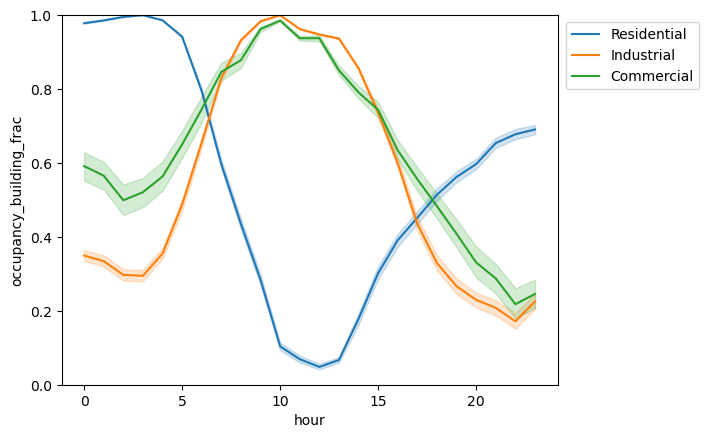

In [11]:
tmp = building_schedule_all.copy()
tmp['occupancy_building_frac'] = tmp.groupby('ID')['occupancy_building_frac'].transform(lambda x: (x - x.min())/ (x.max() - x.min()))
sns.lineplot(data = tmp, y='occupancy_building_frac',x='hour',hue='BuildingClass')
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
plt.ylim(0,1)

In [4]:
season = 'default'
if season == 'default':
    schedule = building_schedule_all[['hour','ID','occupancy_building_frac','BuildingClass']]
elif season == 'summer':
    schedule = building_schedule_summer[['hour','ID','occupancy_building_frac','BuildingClass']]
elif season == 'winter':
    schedule = building_schedule_winter[['hour','ID','occupancy_building_frac','BuildingClass']]

# need to normalize for now otherwise the occupancy seems to be lower
schedule['occupancy_building_frac'] = schedule.groupby('ID')['occupancy_building_frac'].transform(lambda x: (x - x.min())/ (x.max() - x.min()))
schedule = schedule.rename(columns={'occupancy_building_frac':'Occ'})
schedule['hour'] = schedule['hour'] + 1

# to idf format
schedule['Occ'] = np.round(schedule['Occ'],2)
schedule['Time'] = schedule['hour'].astype(str).str.zfill(2)+':00' # "Until: "+
print(len(schedule))
schedule = pd.melt(schedule, id_vars=['ID','BuildingClass','hour'], value_vars=['Time','Occ'])
schedule.loc[schedule.variable=='Time','variable'] = 'Time '+schedule.loc[schedule.variable=='Time','hour'].astype(str)+" {hh:mm}"
schedule.loc[schedule.variable=='Occ','variable'] = 'Value Until Time '+schedule.loc[schedule.variable=='Occ','hour'].astype(str)
schedule = schedule.sort_values(['ID','hour'])
schedule = schedule.groupby('ID').filter(lambda group: group['value'].notna().all())
schedule.head()

C:\Users\mmh\AppData\Local\Temp\ipykernel_23052\2312414678.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schedule['occupancy_building_frac'] = schedule.groupby('ID')['occupancy_building_frac'].transform(lambda x: (x - x.min())/ (x.max() - x.min()))


64824


,ID,BuildingClass,hour,variable,value
0,5007013188323,Residential,1,Time 1 {hh:mm},01:00
64824,5007013188323,Residential,1,Value Until Time 1,0.96
1,5007013188323,Residential,2,Time 2 {hh:mm},02:00
64825,5007013188323,Residential,2,Value Until Time 2,0.98
2,5007013188323,Residential,3,Time 3 {hh:mm},03:00


In [5]:
schedule[schedule['value'].isna()]

,ID,BuildingClass,hour,variable,value


In [6]:
for season in ['default','summer','winter']:
    if season == 'default':
        schedule = building_schedule_all[['hour','ID','occupancy_building_frac','BuildingClass']]
    elif season == 'summer':
        schedule = building_schedule_summer[['hour','ID','occupancy_building_frac','BuildingClass']]
    elif season == 'winter':
        schedule = building_schedule_winter[['hour','ID','occupancy_building_frac','BuildingClass']]
    
    # need to normalize for now otherwise the occupancy seems to be lower
    schedule['occupancy_building_frac'] = schedule.groupby('ID')['occupancy_building_frac'].transform(lambda x: (x - x.min())/ (x.max() - x.min()))
    schedule = schedule.rename(columns={'occupancy_building_frac':'Occ'})
    schedule['hour'] = schedule['hour'] + 1

    print(len(set(schedule.ID)))  
    if season == 'default':
        schedule_occ = schedule.copy()
    elif season == 'summer':
        schedule_occ_summer = schedule.copy()
    elif season == 'winter':
        schedule_occ_winter = schedule.copy()

    # to idf format
    schedule['Occ'] = np.round(schedule['Occ'],2)
    schedule['Time'] = schedule['hour'].astype(str).str.zfill(2)+':00' # "Until: "+
    print(len(schedule))
    schedule = pd.melt(schedule, id_vars=['ID','BuildingClass','hour'], value_vars=['Time','Occ'])
    print(len(schedule))
    schedule.loc[schedule.variable=='Time','variable'] = 'Time '+schedule.loc[schedule.variable=='Time','hour'].astype(str)+" {hh:mm}"
    schedule.loc[schedule.variable=='Occ','variable'] = 'Value Until Time '+schedule.loc[schedule.variable=='Occ','hour'].astype(str)
    schedule = schedule.sort_values(['ID','hour'])
    schedule = schedule.groupby('ID').filter(lambda group: group['value'].notna().all())
    
    if season == 'default':
        occ_formatted = schedule.copy()
    elif season == 'summer':
        occ_formatted_summer = schedule.copy()
    elif season == 'winter':
        occ_formatted_winter = schedule.copy()
schedule_occ_summer.head()

C:\Users\mmh\AppData\Local\Temp\ipykernel_23052\3560669635.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schedule['occupancy_building_frac'] = schedule.groupby('ID')['occupancy_building_frac'].transform(lambda x: (x - x.min())/ (x.max() - x.min()))


2701
64824
129648


C:\Users\mmh\AppData\Local\Temp\ipykernel_23052\3560669635.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schedule['occupancy_building_frac'] = schedule.groupby('ID')['occupancy_building_frac'].transform(lambda x: (x - x.min())/ (x.max() - x.min()))


2701
64824
129648


C:\Users\mmh\AppData\Local\Temp\ipykernel_23052\3560669635.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schedule['occupancy_building_frac'] = schedule.groupby('ID')['occupancy_building_frac'].transform(lambda x: (x - x.min())/ (x.max() - x.min()))


2701
64824
129648


,hour,ID,Occ,BuildingClass
0,1,5007013188323,0.954876,Residential
1,2,5007013188323,0.970494,Residential
2,3,5007013188323,0.988030,Residential
3,4,5007013188323,1.000000,Residential
4,5,5007013188323,0.959796,Residential


In [7]:
occ_formatted_summer.head()

,ID,BuildingClass,hour,variable,value
0,5007013188323,Residential,1,Time 1 {hh:mm},01:00
64824,5007013188323,Residential,1,Value Until Time 1,0.95
1,5007013188323,Residential,2,Time 2 {hh:mm},02:00
64825,5007013188323,Residential,2,Value Until Time 2,0.97
2,5007013188323,Residential,3,Time 3 {hh:mm},03:00


In [8]:
occ_formatted_summer[occ_formatted_summer['value'].isna()]

,ID,BuildingClass,hour,variable,value


# Read IDF

In [9]:
# # step 1: read old and save one by one
# # loc = data_dir+'Buildings/IDF_Fulton/ModelsOrig/'
# loc = data_dir+'Buildings/IDF_Fulton_Orig_2'
# type_subset = ['Schedule:Day:Interval']
# # filenames = random.sample(os.listdir(loc), 5)
# for i in range(len(all_ID)): # len(selected_ID)
#     bname = str(all_ID[i])
#     # filenames = bname + '/'+bname+'.idf'
#     filenames = bname + '.idf'
#     building_set = process_idf(loc,[filenames],type_subset=type_subset,name_subset=[],skip=False)
#     building_set = building_set.reset_index(drop=True)
#     # building_set.to_feather(data_dir+'Buildings/Old Occ/schedule_'+str(bname)+'.feather')
#     building_set.to_feather(data_dir+'Buildings/Old Occ/rural_'+str(bname)+'.feather')
# building_set.head(2)

In [10]:
# # step 2: read new one by one
# building_set = pd.DataFrame([])
# for i in range(len(all_ID)): # 
#     bname = str(all_ID[i])
#     # tmp = pd.read_feather(data_dir+'Buildings/Old Occ/schedule_'+str(bname)+'.feather')
#     tmp = pd.read_feather(data_dir+'Buildings/Old Occ/rural_'+str(bname)+'.feather')
#     building_set = pd.concat([building_set,tmp])
# print(len(set(building_set.ID)))
# building_set = building_set.reset_index(drop=True)
# building_set.to_feather(data_dir+'Buildings/Old Occ/schedule_rural.feather')
# # building_set.to_feather(data_dir+'Buildings/Old Occ/schedule_100BG.feather')

In [11]:
# building_set = pd.read_feather(data_dir+'Buildings/Old Occ/schedule_100BG.feather')
building_set = pd.read_feather(data_dir+'Buildings/Old Occ/schedule_rural.feather')
building_set['ID'] = building_set['ID'].str.split("/", expand=True)[0].astype('int64')
building_set = building_set[building_set.ID.isin(all_ID)]
print(len(set(building_set.ID)))
print('size: '+str(round(building_set.memory_usage(index=True).sum()/1e9,4))+'GB')
building_set.head()

3210
size: 0.1GB


,type,value,name,name2,ID
0,Schedule:Day:Interval,Medium Office HtgSetp SmrDsn|Sun Day,Name,Medium Office HtgSetp SmrDsn|Sun Day,5007013188282
1,Schedule:Day:Interval,Temperature,Schedule Type Limits Name,Medium Office HtgSetp SmrDsn|Sun Day,5007013188282
2,Schedule:Day:Interval,No,Interpolate to Timestep,Medium Office HtgSetp SmrDsn|Sun Day,5007013188282
3,Schedule:Day:Interval,24:00,Time 1 {hh:mm},Medium Office HtgSetp SmrDsn|Sun Day,5007013188282
4,Schedule:Day:Interval,15.6,Value Until Time 1,Medium Office HtgSetp SmrDsn|Sun Day,5007013188282


# Update load

In [12]:
alltypes = building_set.name2.value_counts()
# alltypes.to_csv('alltypes.csv')

In [13]:
def update_load(and_schedule_list,or_schedule_list,no_list,schedule_occ,schedule_occ_old):
    if len(no_list)==0:
        filter_condition = (building_set.type == 'Schedule:Day:Interval') & \
                    (building_set.name2.str.lower().str.contains('|'.join(or_schedule_list))) & \
                    (building_set.name2.str.lower().str.contains('|'.join(and_schedule_list)))
    else:
        filter_condition = (building_set.type == 'Schedule:Day:Interval') & \
                    (building_set.name2.str.lower().str.contains('|'.join(or_schedule_list))) & \
                    (building_set.name2.str.lower().str.contains('|'.join(and_schedule_list)) &
                        ~building_set.name2.str.lower().str.contains('|'.join(no_list)))
    df = building_set.loc[filter_condition]
    df = df[~df['value'].str.contains("[a-zA-Z]").fillna(False)]
    df['cat'] = df.name.str.split().str.get(0)
    n = len(np.unique(df.ID))
    print('Number of buildings: '+str(n))

    schedule = pd.DataFrame()
    for i in np.unique(df.ID):
        group = df[df.ID == i]
        x = group.groupby(['cat'])['value'].apply(lambda df: df.reset_index(drop=True)).unstack().T
        x = x.rename_axis(None, axis=1).reset_index(drop=True)
        x['ID'] = i
        schedule = pd.concat([schedule,x])
    tmp = schedule[schedule.duplicated(['Time','ID'],keep='first') | schedule.duplicated(['Time','ID'],keep='last')]
    print('Buildings with duplicated entries: '+str(len(tmp.ID)))
    schedule['Time'] = pd.to_numeric(schedule['Time'].str.split(":").str.get(0))
    schedule['Value'] = pd.to_numeric(schedule['Value'])
    hours = pd.DataFrame(list(range(1,25)) *n,columns=['Time'])
    hours['ID'] = np.repeat(np.unique(df.ID),24)
    schedule = pd.merge(hours,schedule,how='left',on=['ID','Time']) # somehow there are duplciates
    schedule.drop_duplicates(inplace=True)
    schedule['hour'] = schedule['Time']
    schedule['Value'] = schedule['Value'].fillna(method='bfill')
    # schedule = pd.merge(schedule,building_loc[['ID','BuildingClass']],how='left',on=['ID'])
    schedule['Value'] = pd.to_numeric(schedule['Value']) 

    # get variables
    schedule = pd.merge(schedule,schedule_occ.rename(columns={'hour':'Time'}),on=['Time','ID'])
    schedule = pd.merge(schedule,schedule_occ_old.rename(columns={'Value':'OccOld'}),on=['Time','ID'])
    schedule.drop_duplicates(inplace=True)
    print('Number of buildings double check: '+str(len(set(schedule.ID))))
    min_val = schedule.groupby('ID')['Value']
    schedule['min'] = min_val.transform('min')

    # update schedule
    schedule['ValueNew'] = schedule['Value']
    schedule.loc[schedule['OccOld']==0,'OccOld'] = 0.01 # make sure denominator is not zero
    schedule['ValueNew'] = schedule['min'] + (schedule['Value']-schedule['min'])*schedule['Occ']/schedule['OccOld']
    schedule.loc[schedule['ValueNew']>1,'ValueNew'] = 1 # make sure it does not exceed max frac
    schedule = schedule.drop_duplicates() # remvoe duplicates
    schedule_table = schedule.copy()
    
    # to idf format
    schedule['ValueNew'] = np.round(schedule['ValueNew'],2)
    schedule['Time'] = schedule['hour'].astype(str).str.zfill(2)+':00' # "Until: "+
    schedule = pd.melt(schedule, id_vars=['ID','hour'], value_vars=['Time','ValueNew'])
    schedule.loc[schedule.variable=='Time','variable'] = 'Time '+schedule.loc[schedule.variable=='Time','hour'].astype(str)+" {hh:mm}"
    schedule.loc[schedule.variable=='ValueNew','variable'] = 'Value Until Time '+schedule.loc[schedule.variable=='ValueNew','hour'].astype(str)
    schedule = schedule.sort_values(['ID','hour'])
    schedule.drop_duplicates(inplace=True)
    schedule = schedule.groupby('ID').filter(lambda group: group['value'].notna().all())
    schedule_formatted = schedule.copy()
    
    return(schedule_table,schedule_formatted)

## Format old occupancy

In [14]:
df = building_set.loc[(building_set.type=='Schedule:Day:Interval') & 
                     (building_set.name2.str.lower().str.contains('occ')) & 
                     (building_set.name2.str.lower().str.contains('default', na=False))&
                     (~building_set.name2.str.lower().str.contains('space'))&
                     ~building_set.name2.str.lower().str.contains('wkdy day')]
df = df[~df['value'].str.contains("[a-zA-Z]").fillna(False)]
df['cat'] = df.name.str.split().str.get(0)
n = len(np.unique(df.ID))
print(n)
j = 0
schedule = pd.DataFrame()
for i in np.unique(df.ID):
    group = df[df.ID == i]
    x = group.groupby(['cat'])['value'].apply(lambda df: df.reset_index(drop=True)).unstack().T
    x['ID'] = i
    schedule = pd.concat([schedule,x])
schedule.head()

3210


cat,Time,Value,ID
0,06:00,0,5007013188282
1,07:00,0.1,5007013188282
2,08:00,0.2,5007013188282
3,12:00,0.95,5007013188282
4,13:00,0.5,5007013188282


In [15]:
tmp = schedule[schedule.duplicated(['Time','ID'],keep='first') | schedule.duplicated(['Time','ID'],keep='last')]
len(tmp.ID)

16

In [16]:
schedule_occ_old = schedule.copy()
schedule_occ_old['Time'] = pd.to_numeric(schedule_occ_old['Time'].str.split(":").str.get(0))
schedule_occ_old['Value'] = pd.to_numeric(schedule_occ_old['Value'])
hours = pd.DataFrame(list(range(1,25)) *n,columns=['Time'])
hours['ID'] = np.repeat(np.unique(df.ID),24)
schedule_occ_old = pd.merge(hours,schedule_occ_old,how='left',on=['ID','Time'])
schedule_occ_old.drop_duplicates(inplace=True)
schedule_occ_old['Value'] = schedule_occ_old['Value'].fillna(method='bfill')
# schedule = pd.merge(schedule,building_loc[['ID','BuildingClass']],how='left',on=['ID'])
schedule_occ_old['Value'] = pd.to_numeric(schedule_occ_old['Value'])
schedule_occ_old = pd.merge(schedule_occ_old,schedule_occ[['ID','BuildingClass']],how='left',on='ID')
schedule_occ_old.head()

,Time,ID,Value,BuildingClass
0,1,5007013188282,0.0,NaN
1,2,5007013188282,0.0,NaN
2,3,5007013188282,0.0,NaN
3,4,5007013188282,0.0,NaN
4,5,5007013188282,0.0,NaN


(0.0, 1.0)

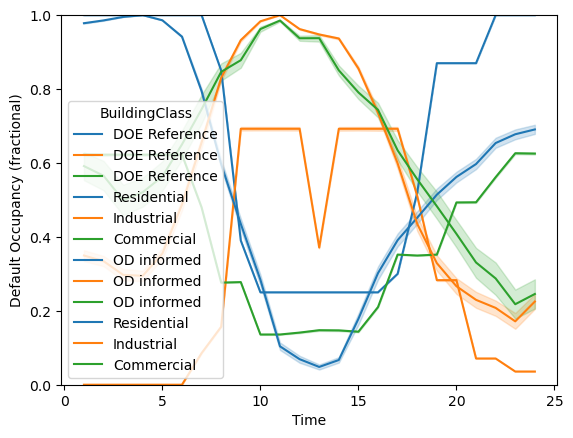

In [17]:
sns.lineplot(data = schedule_occ_old, y='Value',x='Time',hue='BuildingClass',label='DOE Reference')
sns.lineplot(data = schedule_occ, y='Occ',x='hour',hue='BuildingClass',label='OD informed')
plt.ylabel('Default Occupancy (fractional)')
plt.ylim(0,1)

3210
Buildings with duplicated entries: 6


(0.0, 1.0)

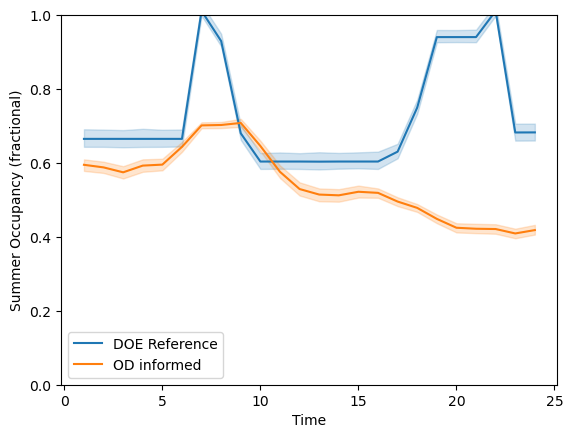

In [18]:
# summer
df = building_set.loc[(building_set.type=='Schedule:Day:Interval') & 
                     (building_set.name2.str.lower().str.contains('occ')) & 
                     (building_set.name2.str.lower().str.contains('summer', na=False))&
                     (~building_set.name2.str.lower().str.contains('space'))&
                     ~building_set.name2.str.lower().str.contains('wkdy day')]
df = df[~df['value'].str.contains("[a-zA-Z]").fillna(False)]
df['cat'] = df.name.str.split().str.get(0)
n = len(np.unique(df.ID))
print(n)
schedule = pd.DataFrame()
for i in np.unique(df.ID):
    group = df[df.ID == i]
    x = group.groupby(['cat'])['value'].apply(lambda df: df.reset_index(drop=True)).unstack().T
    x['ID'] = i
    schedule = pd.concat([schedule,x])
tmp = schedule[schedule.duplicated(['Time','ID'],keep='first') | schedule.duplicated(['Time','ID'],keep='last')]
print('Buildings with duplicated entries: '+str(len(tmp.ID)))
schedule_occ_old_summer = schedule.copy()
schedule_occ_old_summer['Time'] = pd.to_numeric(schedule_occ_old_summer['Time'].str.split(":").str.get(0))
schedule_occ_old_summer['Value'] = pd.to_numeric(schedule_occ_old_summer['Value'])
hours = pd.DataFrame(list(range(1,25)) *n,columns=['Time'])
hours['ID'] = np.repeat(np.unique(df.ID),24)
schedule_occ_old_summer = pd.merge(hours,schedule_occ_old_summer,how='left',on=['ID','Time'])
schedule_occ_old_summer.drop_duplicates(inplace=True)
schedule_occ_old_summer['Value'] = schedule_occ_old_summer['Value'].fillna(method='bfill')
# schedule = pd.merge(schedule,building_loc[['ID','BuildingClass']],how='left',on=['ID'])
schedule_occ_old_summer['Value'] = pd.to_numeric(schedule_occ_old_summer['Value'])
# schedule_occ_old_summer.head()
sns.lineplot(data = schedule_occ_old_summer, y='Value',x='Time',label='DOE Reference')
sns.lineplot(data = schedule_occ_summer, y='Occ',x='hour',label='OD informed')
plt.ylabel('Summer Occupancy (fractional)')
plt.ylim(0,1)

3210
Buildings with duplicated entries: 6


(0.0, 1.0)

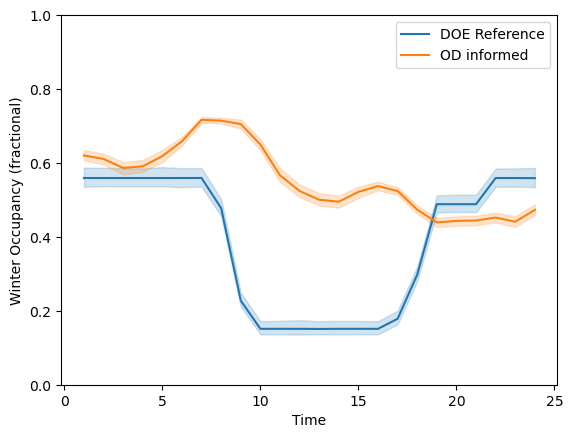

In [19]:
# winter
df = building_set.loc[(building_set.type=='Schedule:Day:Interval') & 
                     (building_set.name2.str.lower().str.contains('occ')) & 
                     (building_set.name2.str.lower().str.contains('winter'))&
                     ~building_set.name2.str.lower().str.contains('space') &
                     ~building_set.name2.str.lower().str.contains('wkdy day')]
df = df[~df['value'].str.contains("[a-zA-Z]").fillna(False)]
df['cat'] = df.name.str.split().str.get(0)
n = len(np.unique(df.ID))
print(n)
schedule = pd.DataFrame()
for i in np.unique(df.ID):
    group = df[df.ID == i]
    x = group.groupby(['cat'])['value'].apply(lambda df: df.reset_index(drop=True)).unstack().T
    x['ID'] = i
    schedule = pd.concat([schedule,x])
tmp = schedule[schedule.duplicated(['Time','ID'],keep='first') | schedule.duplicated(['Time','ID'],keep='last')]
print('Buildings with duplicated entries: '+str(len(tmp.ID)))
schedule_occ_old_winter = schedule.copy()
schedule_occ_old_winter['Time'] = pd.to_numeric(schedule_occ_old_winter['Time'].str.split(":").str.get(0))
schedule_occ_old_winter['Value'] = pd.to_numeric(schedule_occ_old_winter['Value'])
hours = pd.DataFrame(list(range(1,25)) *n,columns=['Time'])
hours['ID'] = np.repeat(np.unique(df.ID),24)
schedule_occ_old_winter = pd.merge(hours,schedule_occ_old_winter,how='left',on=['ID','Time'])
schedule_occ_old_winter.drop_duplicates(inplace=True)
schedule_occ_old_winter['Value'] = schedule_occ_old_winter['Value'].fillna(method='bfill')
# schedule = pd.merge(schedule,building_loc[['ID','BuildingClass']],how='left',on=['ID'])
schedule_occ_old_winter['Value'] = pd.to_numeric(schedule_occ_old_winter['Value'])
# schedule_occ_old.head()
sns.lineplot(data = schedule_occ_old_winter, y='Value',x='Time',label='DOE Reference')
sns.lineplot(data = schedule_occ_winter, y='Occ',x='hour',label='OD informed')
plt.ylabel('Winter Occupancy (fractional)')
plt.ylim(0,1)

## update equipment

In [20]:
and_eqp_list = ['default']
or_eqp_list = ['equip','eqp']
no_list = ['wkdy day','wntrdsn','gas','sun day']
schedule_eqp,eqp_formatted = update_load(and_eqp_list,or_eqp_list,no_list,schedule_occ,schedule_occ_old)
eqp_formatted.head()

Number of buildings: 2957
Buildings with duplicated entries: 4
Number of buildings double check: 2452


,ID,hour,variable,value
0,5007013188323,1,Time 1 {hh:mm},01:00
58848,5007013188323,1,Value Until Time 1,0.45
1,5007013188323,2,Time 2 {hh:mm},02:00
58849,5007013188323,2,Value Until Time 2,0.41
2,5007013188323,3,Time 3 {hh:mm},03:00


In [21]:
eqp_formatted[eqp_formatted['value'].isna()].head()

,ID,hour,variable,value


In [22]:
# tmp = df.groupby('ID')['name2'].nunique().reset_index()
# tmp[tmp.name2>1].head(10)

Text(0, 0.5, 'Default electric equipment schedule (fractional)')

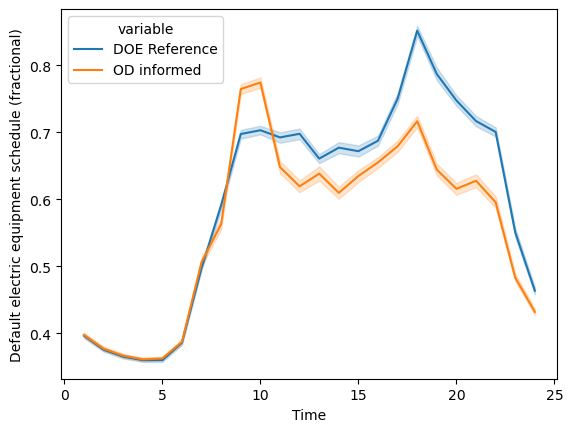

In [23]:
df = pd.melt(schedule_eqp,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Default electric equipment schedule (fractional)')

Number of buildings: 3210
Buildings with duplicated entries: 0
Number of buildings double check: 2701


Text(0, 0.5, 'Summer electric equipment schedule (fractional)')

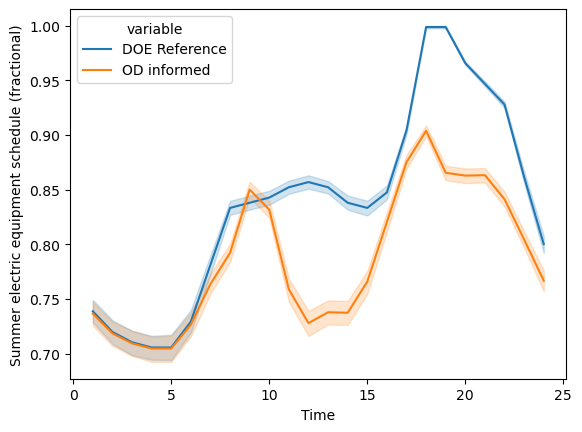

In [24]:
and_eqp_list = ['summer']
or_eqp_list = ['equip','eqp']
no_list = ['wkdy day','wntrdsn','gas','sun day']
schedule_eqp_summer,eqp_formatted_summer = update_load(and_eqp_list,or_eqp_list,no_list,schedule_occ_summer,schedule_occ_old_summer)
eqp_formatted_summer.head()

df = pd.melt(schedule_eqp_summer,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Summer electric equipment schedule (fractional)')

Number of buildings: 3210
Buildings with duplicated entries: 0
Number of buildings double check: 2701


Text(0, 0.5, 'Winter electric equipment schedule (fractional)')

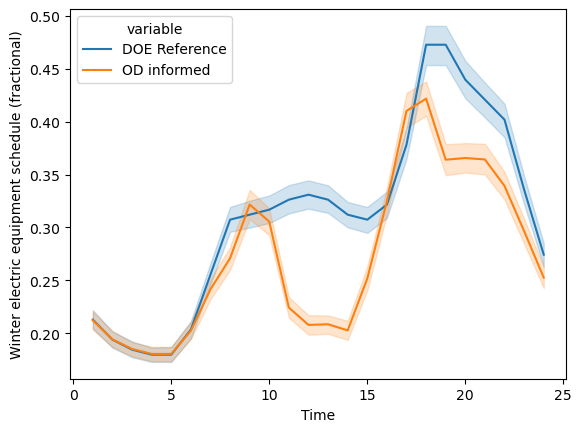

In [25]:
and_eqp_list = ['winter']
or_eqp_list = ['equip','eqp']
no_list = ['wkdy day','wntrdsn','gas','sun day']
schedule_eqp_winter,eqp_formatted_winter = update_load(and_eqp_list,or_eqp_list,no_list,schedule_occ_winter,schedule_occ_old_winter)
eqp_formatted_winter.head()

df = pd.melt(schedule_eqp_winter,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Winter electric equipment schedule (fractional)')

## Lights

In [26]:
and_light_list = ['default']
or_light_list = ['light']
no_list = ['wkdy day','wntrdsn','fan','sun day','exterior']
schedule_light,light_formatted = update_load(and_light_list,or_light_list,no_list,schedule_occ,schedule_occ_old)
light_formatted.head()

Number of buildings: 1814
Buildings with duplicated entries: 0
Number of buildings double check: 1748


,ID,hour,variable,value
0,5007013188411,1,Time 1 {hh:mm},01:00
41952,5007013188411,1,Value Until Time 1,0.05
1,5007013188411,2,Time 2 {hh:mm},02:00
41953,5007013188411,2,Value Until Time 2,0.05
2,5007013188411,3,Time 3 {hh:mm},03:00


Text(0, 0.5, 'Default lights schedule (fractional)')

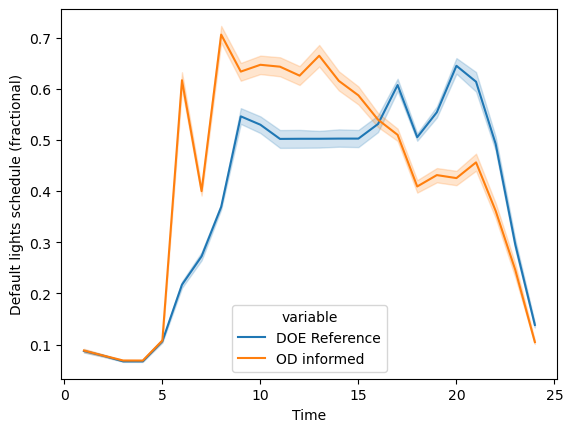

In [27]:
df = pd.melt(schedule_light,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Default lights schedule (fractional)')

Number of buildings: 2067
Buildings with duplicated entries: 0
Number of buildings double check: 1997


Text(0, 0.5, 'Summer light schedule (fractional)')

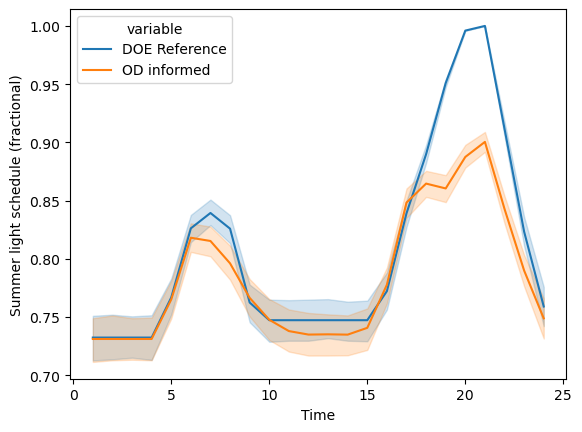

In [28]:
and_light_list = ['summer']
or_light_list = ['light']
no_list = ['wkdy day','wntrdsn','fan','sun day','exterior']
schedule_light_summer,light_formatted_summer = update_load(and_light_list,or_light_list,no_list,schedule_occ_summer,schedule_occ_old_summer)
light_formatted_summer.head()

df = pd.melt(schedule_light_summer,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Summer light schedule (fractional)')

Number of buildings: 2067
Buildings with duplicated entries: 0
Number of buildings double check: 1997


Text(0, 0.5, 'Winter light schedule (fractional)')

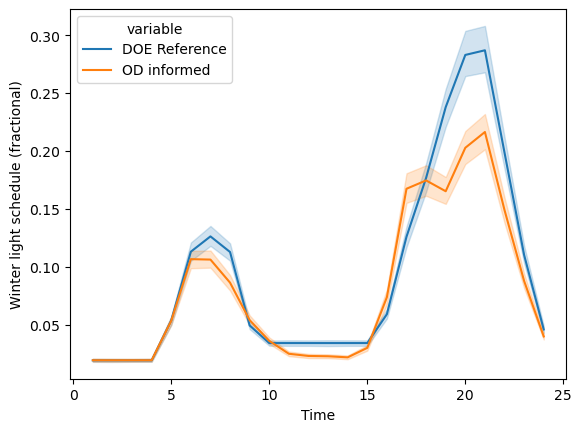

In [29]:
and_light_list = ['winter']
or_light_list = ['light']
no_list = ['wkdy day','wntrdsn','fan','sun day','exterior']
schedule_light_winter,light_formatted_winter = update_load(and_light_list,or_light_list,no_list,schedule_occ_winter,schedule_occ_old_winter)
light_formatted_winter.head()

df = pd.melt(schedule_light_winter,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Winter light schedule (fractional)')

## ThermostatSetpoint:DualSetpoint

Number of buildings: 3208
Buildings with duplicated entries: 0
Number of buildings double check: 2701


Text(0, 0.5, 'Default Heating schedule (fractional)')

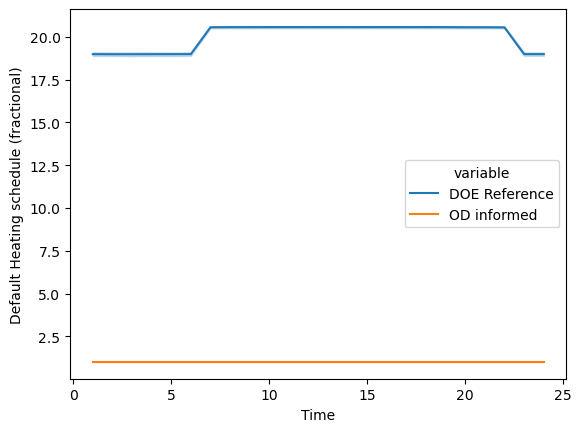

In [30]:
and_htg_list = ['default']
or_htg_list = ['htg']
no_list = ['wkdy day','wntrdsn','sun day']
schedule_htg,htg_formatted = update_load(and_htg_list,or_htg_list,no_list,schedule_occ,schedule_occ_old)
htg_formatted.head()
df = pd.melt(schedule_htg,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Default Heating schedule (fractional)')

Number of buildings: 3208
Buildings with duplicated entries: 0
Number of buildings double check: 2701


Text(0, 0.5, 'Summer Heating schedule (fractional)')

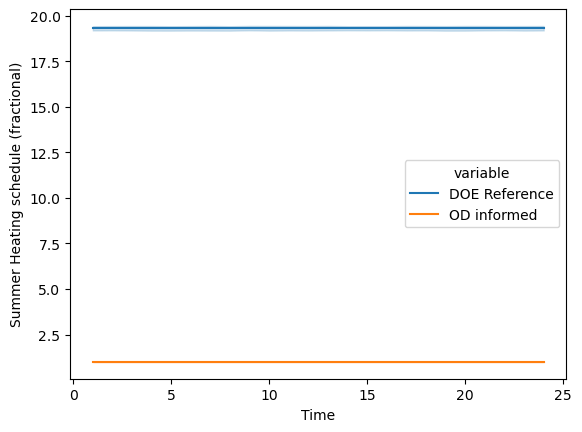

In [31]:
and_htg_list = ['summer']
or_htg_list = ['htg']
no_list = ['wkdy day','wntrdsn','sun day']
schedule_htg_summer,htg_formatted_summer = update_load(and_htg_list,or_htg_list,no_list,schedule_occ_summer,schedule_occ_old_summer)
htg_formatted_summer.head()
df = pd.melt(schedule_htg_summer,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Summer Heating schedule (fractional)')

Number of buildings: 3208
Buildings with duplicated entries: 0
Number of buildings double check: 2701


Text(0, 0.5, 'Winter Heating schedule (fractional)')

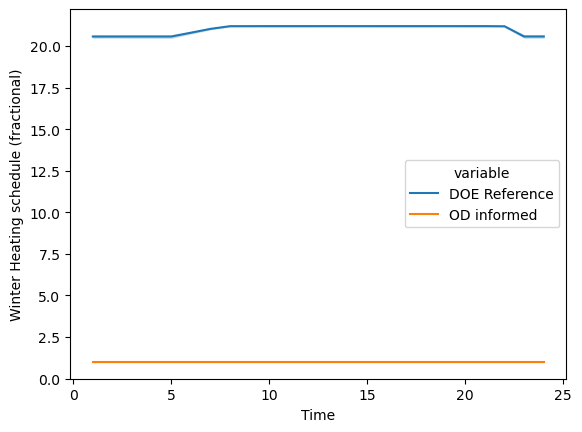

In [32]:
and_htg_list = ['winter']
or_htg_list = ['htg']
no_list = ['wkdy day','wntrdsn','sun day']
schedule_htg_winter,htg_formatted_winter = update_load(and_htg_list,or_htg_list,no_list,schedule_occ_winter,schedule_occ_old_winter)
htg_formatted_winter.head()
df = pd.melt(schedule_htg_winter,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Winter Heating schedule (fractional)')

Number of buildings: 3210
Buildings with duplicated entries: 0
Number of buildings double check: 2701


Text(0, 0.5, 'Default Cooling schedule (fractional)')

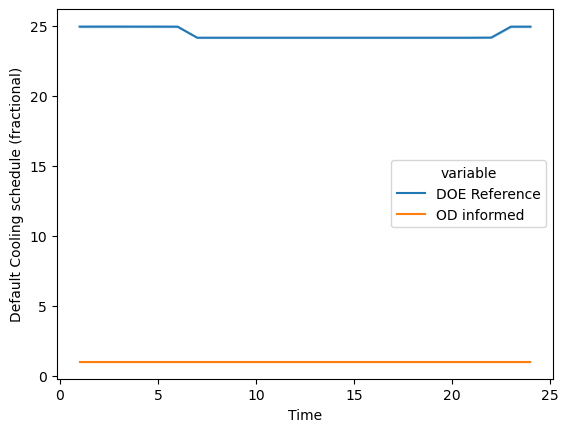

In [33]:
and_clg_list = ['default']
or_clg_list = ['clg']
no_list = ['wkdy day','wntrdsn','sun day']
schedule_clg,clg_formatted = update_load(and_clg_list,or_clg_list,no_list,schedule_occ,schedule_occ_old)
clg_formatted.head()
df = pd.melt(schedule_clg,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Default Cooling schedule (fractional)')

Number of buildings: 3210
Buildings with duplicated entries: 0
Number of buildings double check: 2701


Text(0, 0.5, 'Summer Cooling schedule (fractional)')

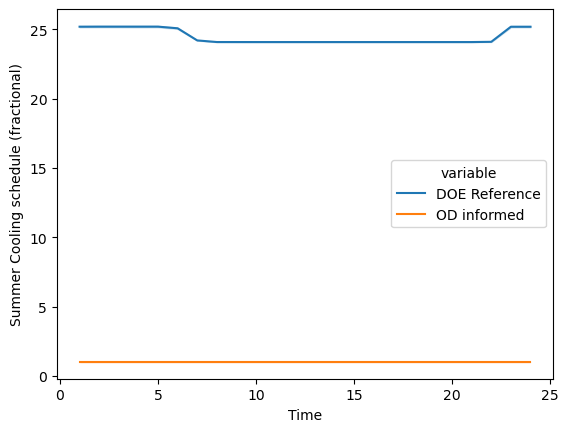

In [34]:
and_clg_list = ['summer']
or_clg_list = ['clg']
no_list = ['wkdy day','wntrdsn','sun day']
schedule_clg_summer,clg_formatted_summer = update_load(and_clg_list,or_clg_list,no_list,schedule_occ_summer,schedule_occ_old_summer)
clg_formatted_summer.head()
df = pd.melt(schedule_clg_summer,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Summer Cooling schedule (fractional)')

Number of buildings: 3210
Buildings with duplicated entries: 0
Number of buildings double check: 2701


Text(0, 0.5, 'Winter Cooling schedule (fractional)')

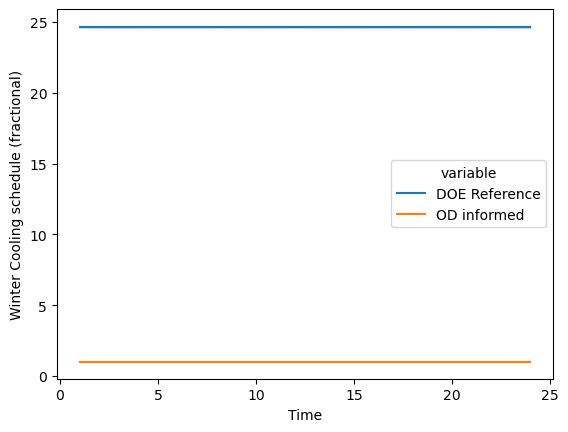

In [35]:
and_clg_list = ['winter']
or_clg_list = ['clg']
no_list = ['wkdy day','wntrdsn','sun day']
schedule_clg_winter,clg_formatted_winter = update_load(and_clg_list,or_clg_list,no_list,schedule_occ_winter,schedule_occ_old_winter)
clg_formatted_winter.head()
df = pd.melt(schedule_clg_winter,id_vars=['ID','Time'],value_vars=['Value','ValueNew'])
df['variable'] = df['variable'].map({'Value':'DOE Reference','ValueNew':'OD informed'})
df.head()
sns.lineplot(data = df, y='value',x='Time',hue = 'variable')
plt.ylabel('Winter Cooling schedule (fractional)')

# Convert new dataframe into building set
- add one schedule "Schedule:Compact" as "Occ_Schedule_New"
- change 'Number of People Schedule Name' to the new schedule
    - change 'Number of People Calculation Method' to "People"
    - change "Number of People" to capacity

In [36]:
def write_building(loc,building_id, # input location and building id (file name)
                   new_dir):# new idf location
    new_schedule_list = ['Occ_Schedule_New','Eqp_Schedule_New','Light_Schedule_New']
    
    file = str(building_id)+'.idf'
    # out_filename = out_dir+str(building_id)+'New.idf'
    new_filename = str(building_id)+'New.idf'
    new_file = new_dir+new_filename
    # filename= os.path.join(loc, str(building_id)+'/'+file) # for the original
    filename= os.path.join(loc, file)

    with open(filename) as file:   
        lines = file.readlines()
    
    ###### day:interval
    ### occ
    # occ default
    if building_id in occ_formatted.ID.values:
        replace_line = ',\n'.join(occ_formatted.loc[occ_formatted.ID==building_id,'value'].astype(str).values)
        replace_line = f'''\nSchedule:Day:Interval,
        Occ_Schedule_New Default, !- Name
        Fractional, !- Schedule Type Limits Name
        No, !- Interpolate to Timestep
        {replace_line};\n\n ''' 
        lines.append(replace_line)

    # occ summer
    if building_id in occ_formatted.ID.values:
        replace_line = ',\n'.join(occ_formatted_summer.loc[occ_formatted_summer.ID==building_id,'value'].astype(str).values)
        replace_line = f'''\nSchedule:Day:Interval,
        Occ_Schedule_New Summer, !- Name
        Fractional, !- Schedule Type Limits Name
        No, !- Interpolate to Timestep
        {replace_line};\n\n ''' 
        lines.append(replace_line)

    # occ winter
    if building_id in occ_formatted.ID.values:
        replace_line = ',\n'.join(occ_formatted_winter.loc[occ_formatted_winter.ID==building_id,'value'].astype(str).values)
        replace_line = f'''\nSchedule:Day:Interval,
        Occ_Schedule_New Winter, !- Name
        Fractional, !- Schedule Type Limits Name
        No, !- Interpolate to Timestep
        {replace_line};\n\n ''' 
        lines.append(replace_line)

    ### equip
    # equip
    if building_id in eqp_formatted.ID.values:
        replace_line = ',\n'.join(eqp_formatted.loc[eqp_formatted.ID==building_id,'value'].astype(str).values)
        replace_line = f'''\nSchedule:Day:Interval,
        Eqp_Schedule_New Default, !- Name
        Fractional, !- Schedule Type Limits Name
        No, !- Interpolate to Timestep
        {replace_line};\n\n ''' 
        lines.append(replace_line)

    # equip summer
    if building_id in eqp_formatted.ID.values:
        replace_line = ',\n'.join(eqp_formatted_summer.loc[eqp_formatted_summer.ID==building_id,'value'].astype(str).values)
        replace_line = f'''\nSchedule:Day:Interval,
        Eqp_Schedule_New Summer, !- Name
        Fractional, !- Schedule Type Limits Name
        No, !- Interpolate to Timestep
        {replace_line};\n\n ''' 
        lines.append(replace_line)

    # equip winter
    if building_id in eqp_formatted.ID.values:
        replace_line = ',\n'.join(eqp_formatted_winter.loc[eqp_formatted_winter.ID==building_id,'value'].astype(str).values)
        replace_line = f'''\nSchedule:Day:Interval,
        Eqp_Schedule_New Winter, !- Name
        Fractional, !- Schedule Type Limits Name
        No, !- Interpolate to Timestep
        {replace_line};\n\n ''' 
        lines.append(replace_line)
    
    ### lights
    # lights
    if building_id in light_formatted.ID.values:
        replace_line = ',\n'.join(light_formatted.loc[light_formatted.ID==building_id,'value'].astype(str).values)
        replace_line = f'''\nSchedule:Day:Interval,
        Light_Schedule_New Default, !- Name
        Fractional, !- Schedule Type Limits Name
        No, !- Interpolate to Timestep
        {replace_line};\n\n ''' 
        lines.append(replace_line)

    # lights summer
    if building_id in light_formatted.ID.values:
        replace_line = ',\n'.join(light_formatted_summer.loc[light_formatted_summer.ID==building_id,'value'].astype(str).values)
        replace_line = f'''\nSchedule:Day:Interval,
        Light_Schedule_New Summer, !- Name
        Fractional, !- Schedule Type Limits Name
        No, !- Interpolate to Timestep
        {replace_line};\n\n ''' 
        lines.append(replace_line)

    # lights winter
    if building_id in light_formatted.ID.values:
        replace_line = ',\n'.join(light_formatted_winter.loc[light_formatted_winter.ID==building_id,'value'].astype(str).values)
        replace_line = f'''\nSchedule:Day:Interval,
        Light_Schedule_New Winter, !- Name
        Fractional, !- Schedule Type Limits Name
        No, !- Interpolate to Timestep
        {replace_line};\n\n ''' 
        lines.append(replace_line)


    ### week:daily schedule: 'Occ_Schedule_New','Eqp_Schedule_New','Light_Schedule_New'    
    if building_id in occ_formatted.ID.values:
        x = 'Occ_Schedule_New'
        new_values = f'''Schedule:Week:Daily,
            {x} Week Rule - Jan1-Dec31, !- Name
            {x} Default, !- Sunday Schedule:Day Name
            {x} Default, !- Monday Schedule:Day Name
            {x} Default, !- Tuesday Schedule:Day Name
            {x} Default, !- Wednesday Schedule:Day Name
            {x} Default, !- Thursday Schedule:Day Name
            {x} Default, !- Friday Schedule:Day Name
            {x} Default, !- Saturday Schedule:Day Name
            {x} Default, !- Holiday Schedule:Day Name
            {x} Summer,  !- SummerDesignDay Schedule:Day Name
            {x} Winter,  !- WinterDesignDay Schedule:Day Name
            {x} Default, !- CustomDay1 Schedule:Day Name
            {x} Default; !- CustomDay2 Schedule:Day Name\n\n '''
        lines.append(new_values)
    
    if building_id in eqp_formatted.ID.values:
        x = 'Eqp_Schedule_New'
        new_values = f'''Schedule:Week:Daily,
            {x} Week Rule - Jan1-Dec31, !- Name
            {x} Default, !- Sunday Schedule:Day Name
            {x} Default, !- Monday Schedule:Day Name
            {x} Default, !- Tuesday Schedule:Day Name
            {x} Default, !- Wednesday Schedule:Day Name
            {x} Default, !- Thursday Schedule:Day Name
            {x} Default, !- Friday Schedule:Day Name
            {x} Default, !- Saturday Schedule:Day Name
            {x} Default, !- Holiday Schedule:Day Name
            {x} Summer,  !- SummerDesignDay Schedule:Day Name
            {x} Winter,  !- WinterDesignDay Schedule:Day Name
            {x} Default, !- CustomDay1 Schedule:Day Name
            {x} Default; !- CustomDay2 Schedule:Day Name\n\n '''
        lines.append(new_values)

    if building_id in light_formatted.ID.values:
        x = 'Light_Schedule_New'
        new_values = f'''Schedule:Week:Daily,
            {x} Week Rule - Jan1-Dec31, !- Name
            {x} Default, !- Sunday Schedule:Day Name
            {x} Default, !- Monday Schedule:Day Name
            {x} Default, !- Tuesday Schedule:Day Name
            {x} Default, !- Wednesday Schedule:Day Name
            {x} Default, !- Thursday Schedule:Day Name
            {x} Default, !- Friday Schedule:Day Name
            {x} Default, !- Saturday Schedule:Day Name
            {x} Default, !- Holiday Schedule:Day Name
            {x} Summer,  !- SummerDesignDay Schedule:Day Name
            {x} Winter,  !- WinterDesignDay Schedule:Day Name
            {x} Default, !- CustomDay1 Schedule:Day Name
            {x} Default; !- CustomDay2 Schedule:Day Name\n\n '''
        lines.append(new_values)

    ### year    
    if building_id in occ_formatted.ID.values:
        x = 'Occ_Schedule_New'
        replace_line = f'''Schedule:Year,
            {x},         !- Name
            Fractional,                             !- Schedule Type Limits Name
            {x} Week Rule - Jan1-Dec31, !- Schedule:Week Name 1
            1,                                      !- Start Month 1
            1,                                      !- Start Day 1
            12,                                     !- End Month 1
            31;                                     !- End Day 1\n\n ''' 
        lines.append(replace_line)
    
    if building_id in eqp_formatted.ID.values:
        x = 'Eqp_Schedule_New'
        replace_line = f'''Schedule:Year,
            {x},         !- Name
            Fractional,                             !- Schedule Type Limits Name
            {x} Week Rule - Jan1-Dec31, !- Schedule:Week Name 1
            1,                                      !- Start Month 1
            1,                                      !- Start Day 1
            12,                                     !- End Month 1
            31;                                     !- End Day 1\n\n ''' 
        lines.append(replace_line)
    
    if building_id in light_formatted.ID.values:
        x = 'Light_Schedule_New'
        replace_line = f'''Schedule:Year,
            {x},         !- Name
            Fractional,                             !- Schedule Type Limits Name
            {x} Week Rule - Jan1-Dec31, !- Schedule:Week Name 1
            1,                                      !- Start Month 1
            1,                                      !- Start Day 1
            12,                                     !- End Month 1
            31;                                     !- End Day 1\n\n ''' 
        lines.append(replace_line)
    
    ### people schedule
    if building_id in occ_formatted.ID.values:
        for i in range(len(lines)):
            if "!- Number of People Schedule Name" in lines[i]:
                sch_index = i
                # print('original value of index '+str(sch_index)+": "+str(lines[i]))
                break

        new_values = f'''Occ_Schedule_New,\n'''
        if sch_index is not None:
            lines[sch_index] = new_values
            # print('new value of index '+str(sch_index)+": "+str(lines[sch_index]))

    ### lights schedule
    if building_id in light_formatted.ID.values:
        sch_index = None
        for i in range(len(lines)):
            line = lines[i]
            if "Lights," in line:
                # ignore the previous lines and start to read lines again
                NextLines = lines[i+1:]
                for j in range(len(NextLines)):
                    line = NextLines[j]
                    if "!- Schedule Name" in line:
                        sch_index = j
                        break
                if sch_index is not None:
                    break
    
        new_values = f'''Light_Schedule_New,\n'''
        if sch_index is not None:
            lines[i+1+sch_index] = new_values
            # print('new value of index '+str(i+1+sch_index)+": "+str(lines[i+1+sch_index]))
    
    ### elec schedule
    if building_id in eqp_formatted.ID.values:
        sch_index = None
        for i in range(len(lines)):
            line = lines[i]
            if "ElectricEquipment," in line:
                # ignore the previous lines and start to read lines again
                NextLines = lines[i+1:]
                for j in range(len(NextLines)):
                    line = NextLines[j]
                    if "!- Schedule Name" in line:
                        sch_index = j
                        # print('original value of index '+str(i+1+sch_index)+": "+str(lines[i+1+sch_index]))
                        break
                if sch_index is not None:
                    break
        new_values = f'''Eqp_Schedule_New,\n'''
        if sch_index is not None:
            lines[i+1+sch_index] = new_values
            # print('new value of index '+str(i+1+sch_index)+": "+str(lines[i+1+sch_index]))
    
    ### Write the contents to the output file
    with open(new_file, 'w') as file:
        file.writelines(lines)
    print('Finish writing building '+str(building_id))

In [37]:
len(set(occ_formatted.ID.values))

2693

In [38]:
len(set(light_formatted.ID.values))

1740

In [39]:
len(set(eqp_formatted.ID.values))

2444

# Write buildings

In [40]:
def copy_file(from_dir, filename, to_dir, newfilename):
    # Ensure the source file exists
    source_path = os.path.join(from_dir, filename)
    if not os.path.exists(source_path):
        print(f"Error: Source file '{filename}' not found in '{from_dir}'.")
        return

    # Create the destination directory if it doesn't exist
    os.makedirs(to_dir, exist_ok=True)

    # Construct the destination path
    destination_path = os.path.join(to_dir, newfilename)

    try:
        # Copy the file
        shutil.copyfile(source_path, destination_path)
        print(f"File '{filename}' copied successfully to '{to_dir}/{newfilename}'.")
    except Exception as e:
        print(f"Error: {e}")

In [42]:
# original_dir = data_dir+'Buildings/IDF_Fulton/ModelsOrig/'
original_dir = data_dir+'Buildings/IDF_Fulton_Orig_2/'
# new_dir = data_dir+'Buildings/IDF_Fulton_New/'
new_dir = data_dir+'Buildings/IDF_Fulton_New_2/'
for i in building_list:
    # file_path = os.path.join(original_dir, str(i), f"{i}.idf")
    file_path = os.path.join(original_dir, f"{i}.idf")
    if os.path.exists(file_path):
        write_building(original_dir,i,new_dir)
    else:
        print(f"The file {file_path} does not exist.")

Finish writing building 5007013188282
Finish writing building 5007013188301
Finish writing building 5007013188306
Finish writing building 5007013188323
Finish writing building 5007013188409
Finish writing building 5007013188411
Finish writing building 5007013188412
Finish writing building 5007013188448
Finish writing building 5007013188459
Finish writing building 5007013188468
Finish writing building 5007013188471
Finish writing building 5007013188474
Finish writing building 5007013188493
Finish writing building 5007013188522
Finish writing building 5007013188525
Finish writing building 5007013188580
Finish writing building 5007013188596
Finish writing building 5007013188597
Finish writing building 5007013188620
Finish writing building 5007013188696
Finish writing building 5007013188802
Finish writing building 5007013188816
Finish writing building 5007013188849
Finish writing building 5007013188870
Finish writing building 5007013188881
Finish writing building 5007013188902
Finish writi

# Run simulation in batch
https://eppy.readthedocs.io/en/latest/runningeplus.html

In [44]:
# #### remove files that are not in downtown 53 BGs
# out_dir = data_dir+'Buildings/OUT/'
# # Get the list of files in the directory
# files = os.listdir(out_dir)
# print(len(files))
# # Filter files that don't start with values from building_list
# del_files = [file for file in files if not any(file.startswith(str(value)) for value in building_list)]
# print(len(del_files))
# # Delete the files
# for file in del_files:
#     file_path = os.path.join(out_dir, file)
#     os.remove(file_path)

In [45]:
# #### remove commercial & industrial files that need to be re-run
# residential_building = building_loc.loc[(building_loc.BuildingClass=='Residential') & (building_loc.ID.isin(all_ID)),'ID'].values.tolist()
# out_dir = data_dir+'Buildings/OUT/'
# # Get the list of files in the directory
# files = os.listdir(out_dir)
# print(len(files))
# # Filter files that don't start with values from residential building_list
# del_files = [file for file in files if not any(file.startswith(str(value)) for value in residential_building)]
# print(len(del_files))
# # Delete the files
# for file in del_files:
#     file_path = os.path.join(out_dir, file)
#     os.remove(file_path)
# files = os.listdir(out_dir)
# print(len(files))

In [47]:
# New inputs simulation
# new_dir = data_dir+'Buildings/IDF_Fulton_New/'
new_dir = data_dir+'Buildings/IDF_Fulton_New_2/'
# out_dir = data_dir+'Buildings/OUT/'
out_dir = data_dir+'Buildings/OUT_2/'
weather = data_dir+'Buildings/residential(IECC)_epw/USA_GA_Atlanta-Hartsfield.Jackson.Intl.AP.722190_TMY3.epw'
weather_other = data_dir+'Buildings/commercial_epw/USA_GA_Atlanta-Hartsfield.Jackson.Intl.AP.722190_TMY3.epw'
k = 0
for i in building_list:
    inp_filename = new_dir+str(i)+'New.idf'
    if os.path.exists(inp_filename): # if buildings are in the inputfiles lists
        building_type = building_loc.loc[building_loc.ID==i,'BuildingClass'].values[0]
        if not any(fname.startswith(str(i)) for fname in os.listdir(out_dir)): # not yet runned
            if building_type == 'Residential':
                try:
                    idf = IDF(r'%s' % inp_filename, epw=weather)
                    idf.run(output_directory=out_dir, output_prefix=str(i))
                except Exception as e:
                    print(f"Error processing {inp_filename}: {e}")
                    continue  # Continue to the next iteration even if there's an error
                k = k + 1
                
            else:
                try:
                    idf = IDF(r'%s' % inp_filename, epw=weather_other)
                    idf.run(output_directory=out_dir, output_prefix=str(i))
                except Exception as e:
                    print(f"Error processing {inp_filename}: {e}")
                    continue  # Continue to the next iteration even if there's an error
                k = k + 1
    # get the total number of buildings being simulated in the folder
    files = os.listdir(out_dir)
    # Extract the first 13 characters from each file name
    start_numbers = [file[:13] for file in files]
    # Get the number of unique strings
    unique_strings_count = len(set(start_numbers))
    print('Finish '+building_type+ ' '+str(i)+'. Total number of buildings now is '+str(unique_strings_count))

print(k)

Finish Industrial 5007013188282. Total number of buildings now is 947
Finish Residential 5007013188301. Total number of buildings now is 947
Finish Commercial 5007013188306. Total number of buildings now is 947
Finish Residential 5007013188323. Total number of buildings now is 947
Finish Residential 5007013188409. Total number of buildings now is 947
Finish Industrial 5007013188411. Total number of buildings now is 947
Finish Commercial 5007013188412. Total number of buildings now is 947
Finish Residential 5007013188448. Total number of buildings now is 947
Finish Residential 5007013188459. Total number of buildings now is 947
Finish Industrial 5007013188468. Total number of buildings now is 947
Finish Residential 5007013188471. Total number of buildings now is 947
Finish Industrial 5007013188474. Total number of buildings now is 947
Finish Commercial 5007013188493. Total number of buildings now is 947
Finish Residential 5007013188522. Total number of buildings now is 947
Finish Indust

In [ ]:
# find index
building_list.index(5009016299955)

8361

In [ ]:
# exist in the file?
i = building_list[8361]
out_dir = data_dir+'Buildings/OUT/'
any(fname.startswith(str(i)) for fname in os.listdir(out_dir))

True

In [5]:
# Old files simulation (1361 minutes)
# original_dir = data_dir+'Buildings/IDF_Fulton/ModelsOrig/'
original_dir = data_dir+'Buildings/IDF_Fulton_Orig_2/'
# out_dir = data_dir+'Buildings/OUT_Original/'
out_dir = data_dir+'Buildings/OUT_Original_2/'
weather = data_dir+'Buildings/residential(IECC)_epw/USA_GA_Atlanta-Hartsfield.Jackson.Intl.AP.722190_TMY3.epw'
weather_other = data_dir+'Buildings/commercial_epw/USA_GA_Atlanta-Hartsfield.Jackson.Intl.AP.722190_TMY3.epw'
for i in building_list:
    # inp_filename = original_dir+str(i)+'/'+str(i)+'.idf'  
    inp_filename = original_dir+ str(i)+'.idf'   
    if os.path.exists(inp_filename): # if buildings are in the inputfiles lists
        building_type = building_loc.loc[building_loc.ID==i,'BuildingClass'].values[0]
        if not any(fname.startswith(str(i)) for fname in os.listdir(out_dir)): # not yet runned
            if building_type == 'Residential':
                try:
                    idf = IDF(r'%s' % inp_filename, epw=weather)
                    idf.run(output_directory=out_dir, output_prefix=str(i))
                except Exception as e:
                    print(f"Error processing {inp_filename}: {e}")
                
            else:
                try:
                    idf = IDF(r'%s' % inp_filename, epw=weather_other)
                    idf.run(output_directory=out_dir, output_prefix=str(i))
                except Exception as e:
                    print(f"Error processing {inp_filename}: {e}")
                    continue  # Continue to the next iteration even if there's an error

        # get the total number of buildings being simulated in the folder
        files = os.listdir(out_dir)
        # Extract the first 13 characters from each file name
        start_numbers = [file[:13] for file in files]
        # Get the number of unique strings
        unique_strings_count = len(set(start_numbers))
        print('Finish '+building_type+ ' '+str(i)+'. Total number of buildings now is '+str(unique_strings_count))

Finish Industrial 5007013188282. Total number of buildings now is 1340
Finish Residential 5007013188301. Total number of buildings now is 1340
Finish Commercial 5007013188306. Total number of buildings now is 1340
Finish Residential 5007013188323. Total number of buildings now is 1340
Finish Residential 5007013188409. Total number of buildings now is 1340
Finish Industrial 5007013188411. Total number of buildings now is 1340
Finish Commercial 5007013188412. Total number of buildings now is 1340
Finish Residential 5007013188448. Total number of buildings now is 1340
Finish Residential 5007013188459. Total number of buildings now is 1340
Finish Industrial 5007013188468. Total number of buildings now is 1340
Finish Residential 5007013188471. Total number of buildings now is 1340
Finish Industrial 5007013188474. Total number of buildings now is 1340
Finish Commercial 5007013188493. Total number of buildings now is 1340
Finish Residential 5007013188522. Total number of buildings now is 1340